In [1]:
import numpy as np
import pandas as pd
from glob import glob
import datetime
from pyproj import Transformer
import matplotlib.pyplot as plt
import wradlib as wrl
import re


In [2]:
remove_cycle = lambda x,c : (x[c] + (np.cumsum(x[c:].values - x[:-c]))/c).shift(c)

In [3]:
cycle_length = 24

In [4]:
# df_inputs = pd.read_pickle('2020_input_data')
# df_inputs = df_inputs.iloc[:,[0,-1]]

df_inputs = pd.read_pickle('./2020_input_data_four_areas')
df_inputs = df_inputs.iloc[:,[0,-1,-2,-3,-4]]

df_target = pd.read_pickle('../Drainage data/drainage_ANA_target')

df_target = remove_cycle(df_target,cycle_length)

inputs = df_inputs.dropna()
target = df_target.dropna()


df_target_2 = pd.read_pickle('../Drainage data/drainage_ING_target')
df_target_2 = remove_cycle(df_target_2,cycle_length)
target_2 = df_target_2.dropna().iloc[1800:]

# common_index = inputs.index.intersection(target.index)
common_index = inputs.index.intersection(target.index).intersection(target_2.index)
inputs = inputs.loc[common_index].resample('1h').interpolate(method='linear')
target = target.loc[common_index].resample('1h').interpolate(method='linear')
target_2 = target_2.loc[common_index].resample('1h').interpolate(method='linear')

inputs = inputs.values
target = target.values
target_2 = target_2.values

target = np.c_[target,target_2]

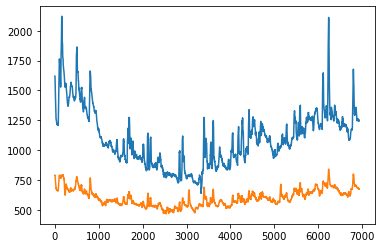

In [5]:
plt.plot(target)

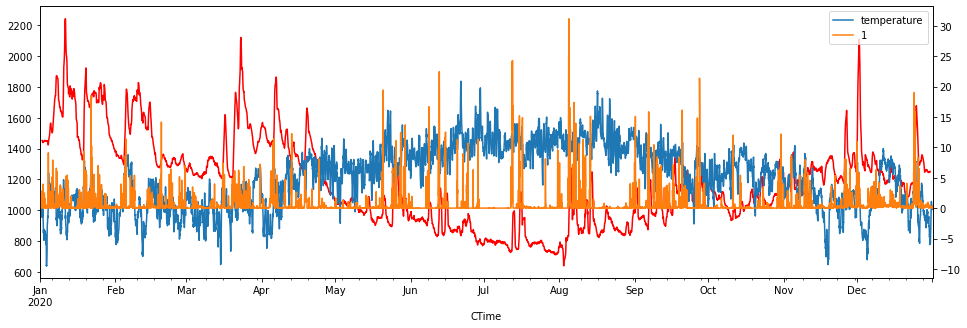

(439888.0, 440688.0)

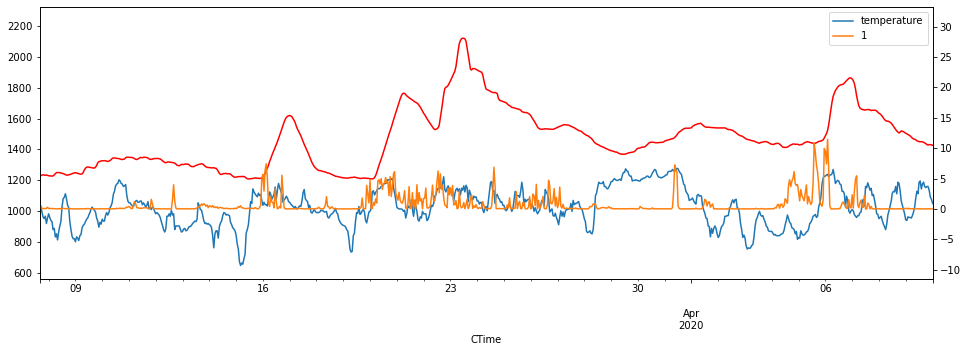

In [6]:
plt.figure(figsize=(16,5))
df_target.plot(color='red')
df_inputs.iloc[:,[0,-1]].plot(ax = plt.twinx())
plt.legend()
plt.show()


plt.figure(figsize=(16,5))
df_target.plot(color='red')
df_inputs.iloc[:,[0,-1]].plot(ax = plt.twinx())
plt.legend()
plt.xlim(df_inputs.index[1600],df_inputs.index[2400])

In [7]:
# x_tmp = range(-100,100)
# y_tmp = [np.corrcoef(np.roll(inputs[:,-1].ravel(),i),target.ravel())[0,1] for i in x_tmp]
# plt.plot(x_tmp,y_tmp)

In [14]:

import torch
import torch.nn as nn
from torch.optim import lr_scheduler as lrs
torch.set_default_dtype(torch.float32)

class Model(nn.Module):
    def __init__(self):
        """Initialize Wrapper for LSTM
        """
        super(Model, self).__init__()
        n_hidden = 3
        n_out = 2
        n_in = 5
        self.rnn = nn.LSTM(input_size=n_in, hidden_size=n_hidden)
        # self.fc = nn.Linear(n_hidden, 1)
        self.fc = nn.Linear(3, n_out)
        self.fc1 = nn.Linear(n_hidden, 1)
        self.fc2 = nn.Linear(n_hidden, 1)
        self.fc3 = nn.Linear(n_hidden, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Perform forward pass.
        :param x: Tensor with dynamic input features.
        :return: Tensor containing the model predictions.
        """
        # make prediction from last time step
        rnn_output, (hn, cn) = self.rnn(x)
        # print(rnn_output.shape, hn.shape, cn.shape)
        output1 = self.fc1(cn)
        output2 = self.fc2(hn)
        output3 = self.fc3(rnn_output[[-1]])
        output_tmp = torch.cat((output1,output2,output3), dim=2)
        output = self.fc(output_tmp)
        return output, hn, cn

In [15]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)
model = Model().to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
# lr_scheduler = lrs.MultiStepLR(optimizer, milestones=[10, 20, 30, 40, 50], gamma=0.1)
loss_func = torch.nn.MSELoss()
# loss_func = torch.nn.L1Loss()

cuda:0


In [16]:
# output_sequences.shape

In [17]:
from torch.utils.data import DataLoader,TensorDataset
# from torch.utils.data. import 
val_ratio = 0.5
sequence_size = 2*7*24 # 4 weeks in hours
batch_size = 32

n_train = int(len(inputs)*(1-val_ratio))
n_input_variables = inputs.shape[1]

input_sequences = np.lib.stride_tricks.sliding_window_view(inputs,(sequence_size,n_input_variables)).squeeze()
output_sequences = np.lib.stride_tricks.sliding_window_view(target,(sequence_size,2)).squeeze()

output_sequences = output_sequences-np.mean(output_sequences,axis = (0,1))

input_sequences = torch.from_numpy(np.array(input_sequences,dtype='float32')).to(DEVICE)
output_sequences = torch.from_numpy(np.array(output_sequences,dtype='float32')).to(DEVICE)


X_train = input_sequences[:n_train]
y_train = output_sequences[:n_train,-1]
X_val = input_sequences[n_train:]
y_val = output_sequences[n_train:,-1]

training_dataset = TensorDataset(X_train,y_train)
validation_dataset = TensorDataset(X_val,y_val)

training_data_loader = DataLoader(training_dataset, batch_size=batch_size)
validation_data_loader = DataLoader(validation_dataset, batch_size=len(input_sequences) - n_train)

# Check that dtypes match
# tmp_input = [i[0] for i in training_dataset]
# tmp_input = tmp_input.permute((1,0,2)).to(DEVICE)
# assert tmp_input.dtype == optimizer.param_groups[0]['params'][0][0].dtype
# output = model.forward(tmp_input)

In [18]:
# model(X_val)[0].shape,y_val.shape,len(input_sequences),len(output_sequences),n_train

Epoch 1 - Training loss 30951.00747960642 - Test loss 18464.19921875
Epoch 2 - Training loss 22896.203196744307 - Test loss 22166.5078125
Epoch 3 - Training loss 21432.160287489583 - Test loss 20584.169921875
Epoch 4 - Training loss 19783.577245379805 - Test loss 19006.51953125
Epoch 5 - Training loss 19607.31370866408 - Test loss 18060.73046875


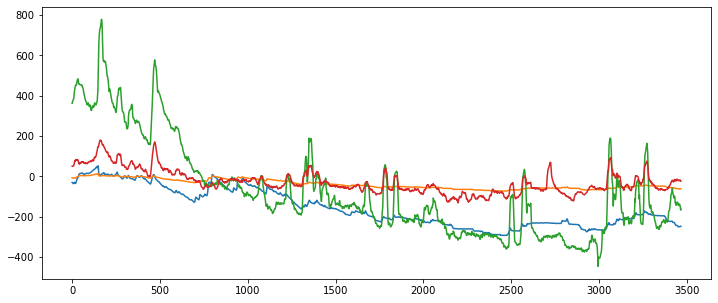

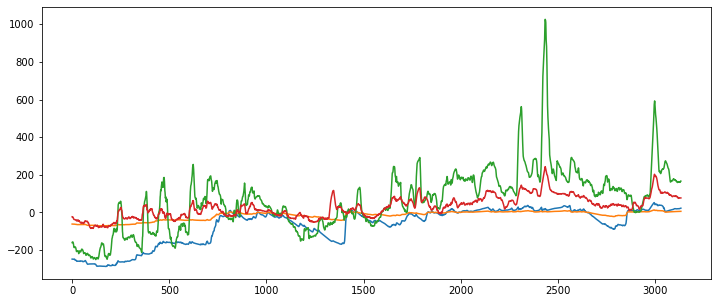

Epoch 6 - Training loss 17956.35869633386 - Test loss 15674.2958984375
Epoch 7 - Training loss 16921.370303722695 - Test loss 13046.91015625
Epoch 8 - Training loss 15893.576158856033 - Test loss 9541.70703125
Epoch 9 - Training loss 14309.004422144058 - Test loss 9347.5869140625
Epoch 10 - Training loss 12187.830519264991 - Test loss 11894.4365234375


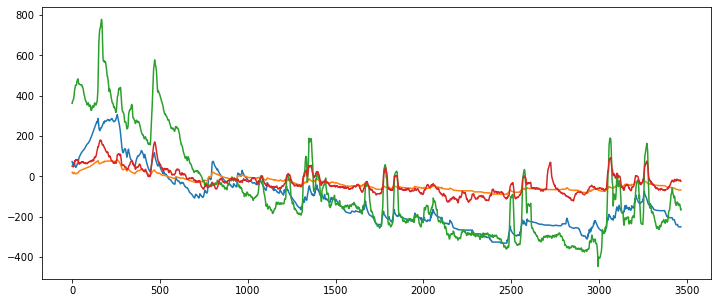

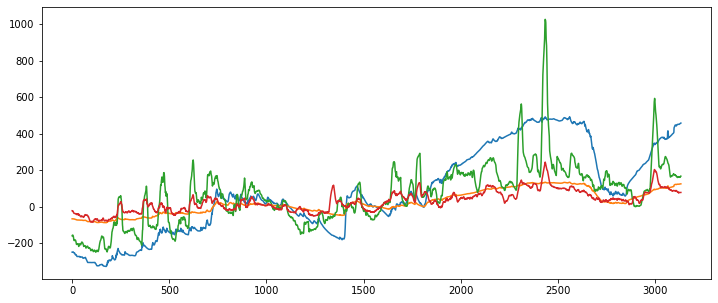

Epoch 11 - Training loss 9061.11969568095 - Test loss 25686.359375
Epoch 12 - Training loss 6068.282756210467 - Test loss 21118.15625
Epoch 13 - Training loss 5667.6963703960455 - Test loss 25449.009765625
Epoch 14 - Training loss 5444.56197644155 - Test loss 28711.099609375
Epoch 15 - Training loss 5244.79657094413 - Test loss 26945.169921875


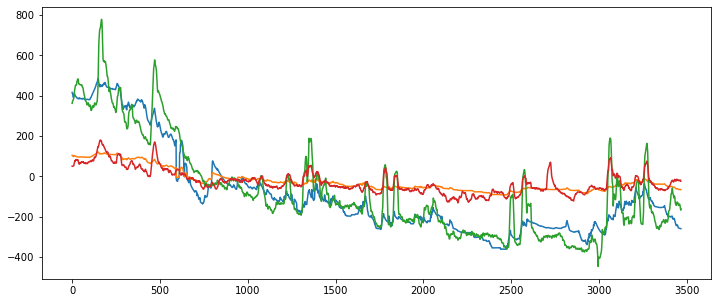

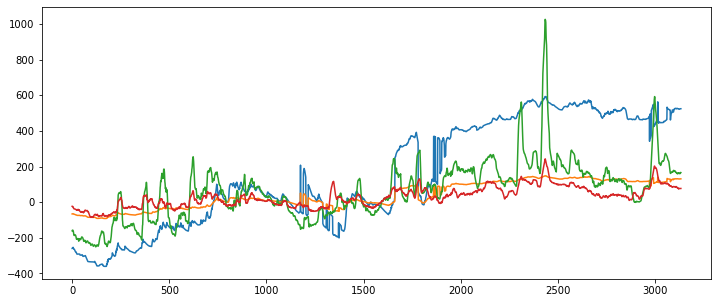

Epoch 16 - Training loss 4858.153668884837 - Test loss 24294.02734375
Epoch 17 - Training loss 4779.199892201555 - Test loss 21250.380859375
Epoch 18 - Training loss 5516.989441337935 - Test loss 27636.94921875
Epoch 19 - Training loss 5145.4506649752275 - Test loss 29853.197265625
Epoch 20 - Training loss 4641.955900419743 - Test loss 30409.212890625


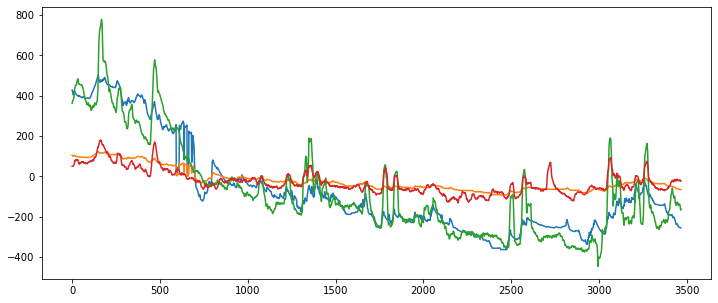

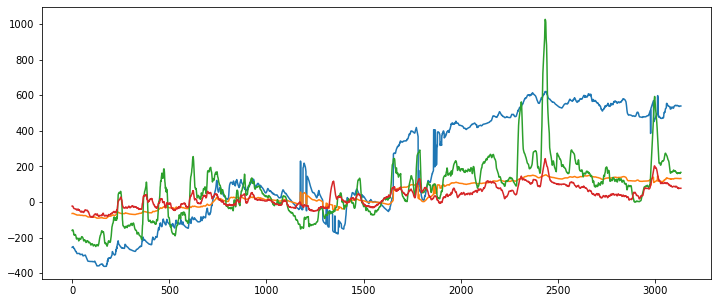

Epoch 21 - Training loss 4517.302192478005 - Test loss 28745.685546875
Epoch 22 - Training loss 4412.828596762561 - Test loss 27574.576171875
Epoch 23 - Training loss 4414.801529070653 - Test loss 27773.20703125
Epoch 24 - Training loss 4386.716599210687 - Test loss 27274.1484375
Epoch 25 - Training loss 4445.562037056739 - Test loss 28461.611328125


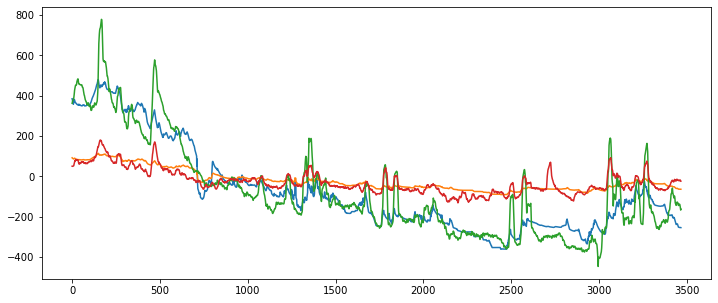

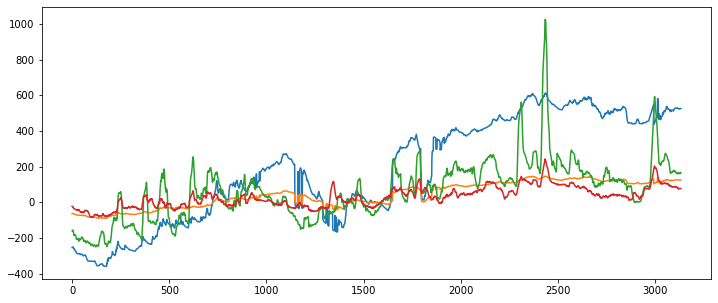

Epoch 26 - Training loss 4376.881449008207 - Test loss 26316.552734375
Epoch 27 - Training loss 4409.388435013797 - Test loss 27253.880859375
Epoch 28 - Training loss 4372.137121918005 - Test loss 29153.306640625
Epoch 29 - Training loss 4325.887168954272 - Test loss 29985.11328125
Epoch 30 - Training loss 4338.548370501317 - Test loss 28637.78515625


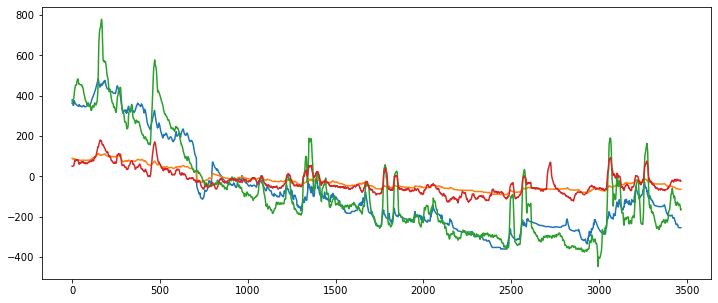

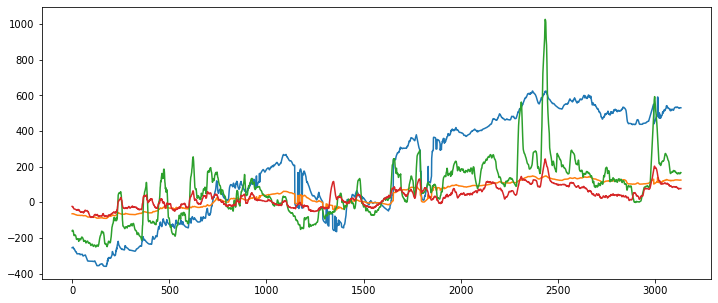

Epoch 31 - Training loss 4258.831094444345 - Test loss 29269.302734375
Epoch 32 - Training loss 4256.957995283495 - Test loss 27152.046875
Epoch 33 - Training loss 4260.063993961439 - Test loss 28238.205078125
Epoch 34 - Training loss 4229.771775691881 - Test loss 28375.931640625
Epoch 35 - Training loss 4174.418039164412 - Test loss 28806.525390625


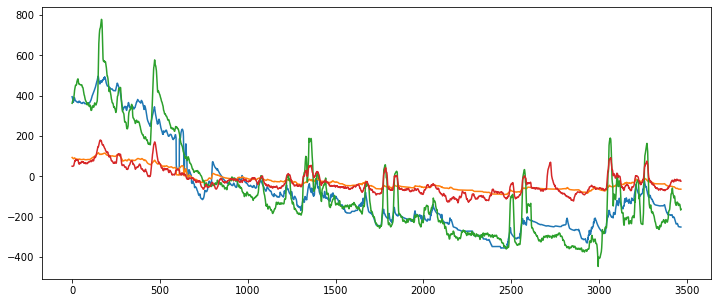

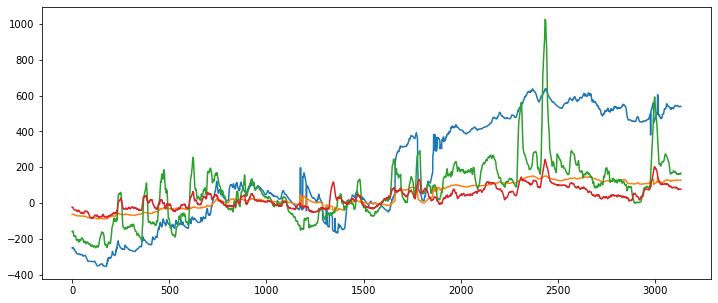

Epoch 36 - Training loss 4152.851452048765 - Test loss 28812.548828125
Epoch 37 - Training loss 4143.482555144424 - Test loss 29039.962890625
Epoch 38 - Training loss 4141.805086748315 - Test loss 29006.224609375
Epoch 39 - Training loss 4137.966302154261 - Test loss 29262.412109375
Epoch 40 - Training loss 4133.673005970246 - Test loss 29132.82421875


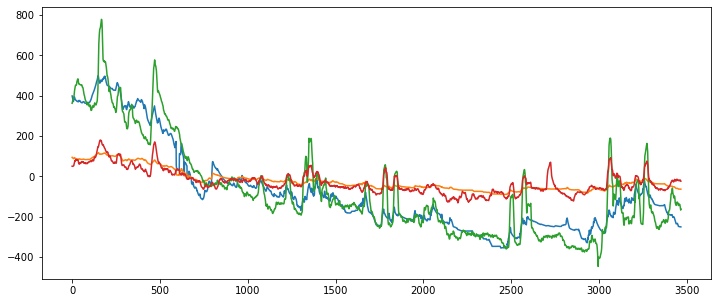

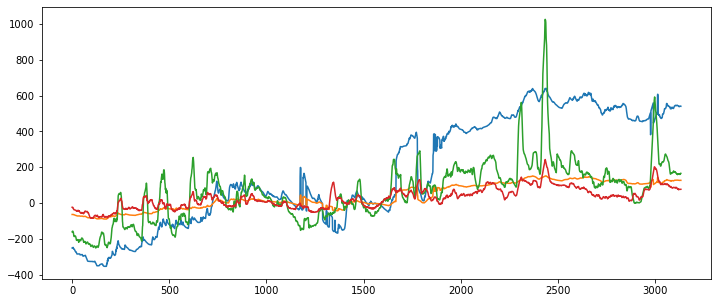

Epoch 41 - Training loss 4144.540409473104 - Test loss 29394.6875
Epoch 42 - Training loss 4129.009619756576 - Test loss 29376.955078125
Epoch 43 - Training loss 4124.8708430298975 - Test loss 29495.72265625
Epoch 44 - Training loss 4123.809442222665 - Test loss 29471.69921875
Epoch 45 - Training loss 4124.293992488756 - Test loss 29679.642578125


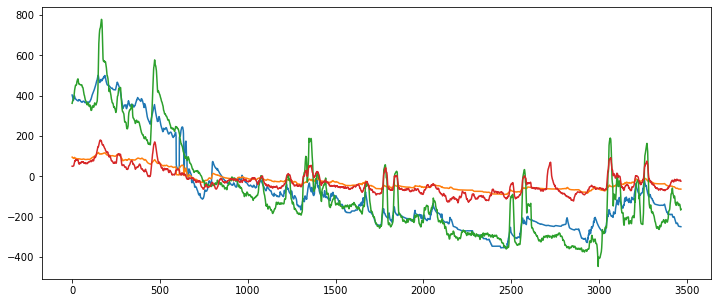

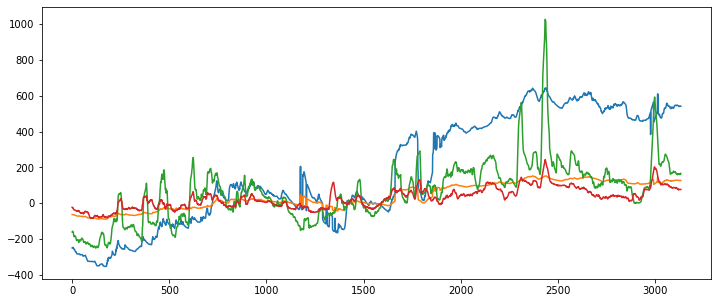

Epoch 46 - Training loss 4125.665072519845 - Test loss 29513.96875
Epoch 47 - Training loss 4121.218254299339 - Test loss 29724.31640625
Epoch 48 - Training loss 4120.888150836349 - Test loss 29497.9921875
Epoch 49 - Training loss 4123.167986668578 - Test loss 29783.671875
Epoch 50 - Training loss 4111.264236170217 - Test loss 29690.62890625


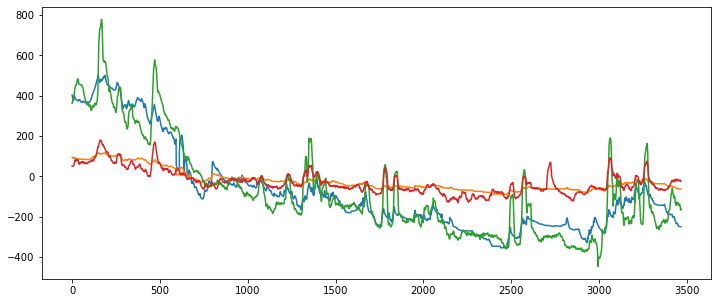

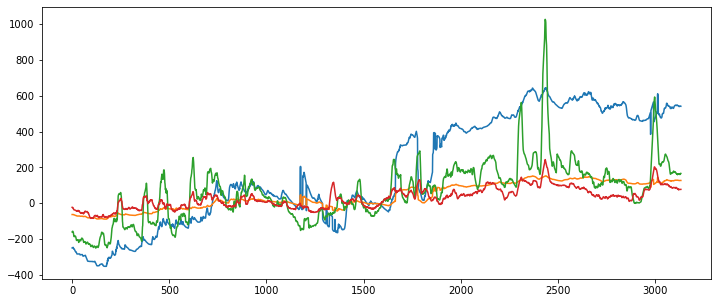

Epoch 51 - Training loss 4105.258049501192 - Test loss 29767.283203125
Epoch 52 - Training loss 4103.003224784081 - Test loss 29686.32421875
Epoch 53 - Training loss 4101.346483283087 - Test loss 29825.935546875
Epoch 54 - Training loss 4100.199829941495 - Test loss 29683.849609375
Epoch 55 - Training loss 4099.851614015912 - Test loss 29925.833984375


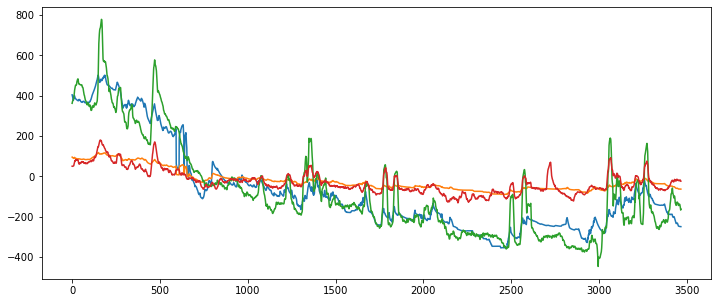

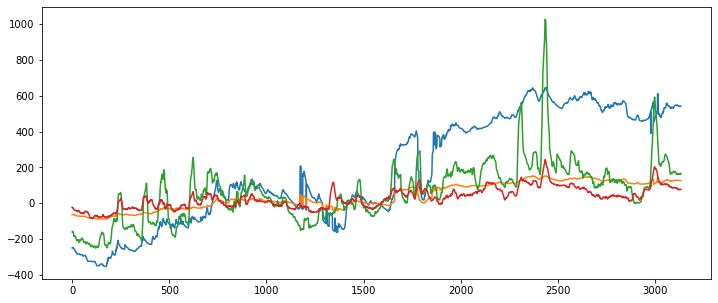

Epoch 56 - Training loss 4113.405647067849 - Test loss 29603.193359375
Epoch 57 - Training loss 4110.907788197928 - Test loss 29812.740234375
Epoch 58 - Training loss 4089.0784007781144 - Test loss 29832.75390625
Epoch 59 - Training loss 4089.0548375680905 - Test loss 29833.482421875
Epoch 60 - Training loss 4088.8248615789853 - Test loss 29905.58984375


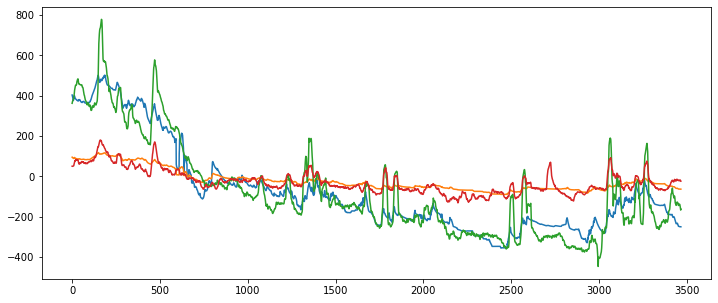

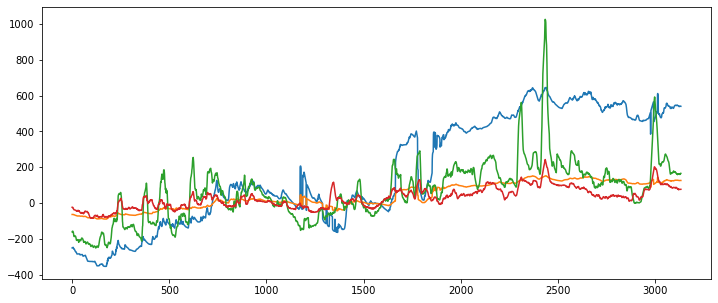

Epoch 61 - Training loss 4087.2698067481365 - Test loss 29889.8515625
Epoch 62 - Training loss 4085.4567647111526 - Test loss 29924.806640625
Epoch 63 - Training loss 4082.7866742895285 - Test loss 29905.54296875
Epoch 64 - Training loss 4079.6923812726222 - Test loss 29906.021484375
Epoch 65 - Training loss 4078.1041326960294 - Test loss 29910.923828125


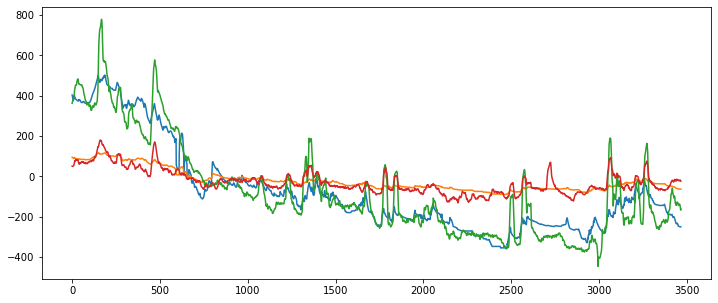

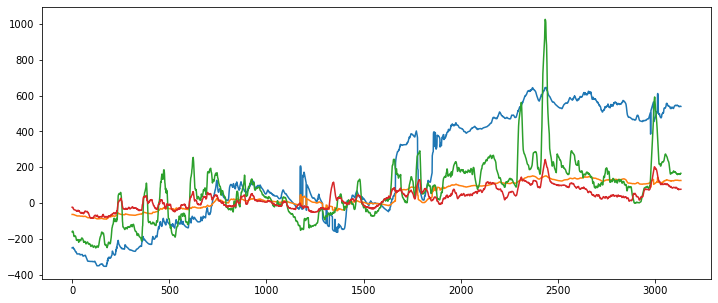

Epoch 66 - Training loss 4079.5569518203038 - Test loss 29980.27734375
Epoch 67 - Training loss 4074.9227423711654 - Test loss 29959.72265625
Epoch 68 - Training loss 4073.638365019352 - Test loss 29972.40234375
Epoch 69 - Training loss 4071.7192672589504 - Test loss 29950.814453125
Epoch 70 - Training loss 4069.2343838193 - Test loss 29956.033203125


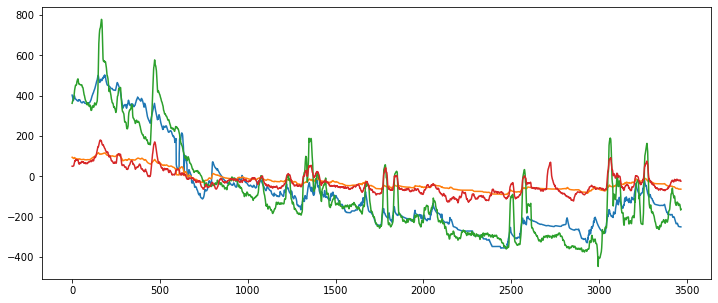

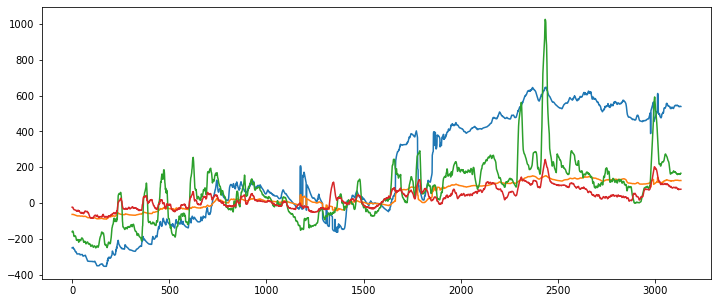

KeyboardInterrupt: 

In [19]:


# Start training cycle
global_step = 1

n_samples = len(training_data_loader.dataset)
n_steps = np.ceil(n_samples / training_data_loader.batch_size).astype(np.int32)

learning_rates = {#1:5e-2,
                  10: 2e-3,
                  20: 1e-3,
                  30: 5e-4,
                  35: 1e-4}

for epoch in range(1, 1000):
    if epoch in learning_rates.keys():
        for param_group in optimizer.param_groups:
            param_group["lr"] = learning_rates[epoch]
            
    # Train routine for a single epoch
    model.train()
    epoc_losses = []
    trues = []
    for i, (x, y) in enumerate(training_data_loader):
        x, y = x.permute((1,0,2)).to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        predictions, *_ = model(x)
        
        loss = loss_func(predictions.squeeze(), y.squeeze())
        # calculate gradients
        loss.backward()
        # perform parameter update
        optimizer.step()
        # lr_scheduler.step()

        # if (i + 1) % 1 == 0:
        # print(loss.item(),end='\r')
        epoc_losses.append(loss.item())
        
    model.eval()
    preds, obs = None, None
    with torch.no_grad():
        for i, (x, y) in enumerate(validation_data_loader):
            x, y = x.permute((1,0,2)).to(DEVICE), y.to(DEVICE)
            val_pred,*_ = model(x)
            val_loss = loss_func(val_pred.squeeze(),y)
            # train_error = loss = loss_func(predictions.squeeze(), y)
            print(f"Epoch {epoch} - Training loss {np.mean(epoc_losses)} - Test loss {np.mean(val_loss.item())}")

                # if cfg["tensorboard"]:
                #     writer.add_scalar('train/loss', loss.item(), global_step)

        if (global_step % 5) == 0:
            y_train_pred,*_= model(X_train.permute((1,0,2)))
            plt.figure(figsize=(12,5))
            plt.plot(y_train_pred.squeeze().cpu().detach().numpy())
            plt.plot(y_train.cpu().detach().numpy())
            plt.show()
            
            y_val_pred,*_= model(X_val.permute((1,0,2)))
            plt.figure(figsize=(12,5))
            plt.plot(y_val_pred.squeeze().cpu().detach().numpy())
            plt.plot(y_val.cpu().detach().numpy())
            plt.show()
            
            
        
    # Evaluation routine on validation set
    if (global_step % 100) == 0:
    
        weight_file =  f'model_state/model_epoch{epoch}.pt'
        torch.save(model.state_dict(), str(weight_file))
        
    global_step += 1

In [ ]:
# np.any(np.isnan(inputs))  

In [ ]:
output = model(X_train)

In [ ]:
X_train.permute()

In [ ]:
[i.shape for i in output]